In [1]:
# Using HD-BET for skull stripping, installed from the repository here: https://github.com/MIC-DKFZ/HD-BET
#
# Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, 
# Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, 
# Kickingereder P. Automated brain extraction of multi-sequence MRI using 
# artificial neural networks. Hum Brain Mapp. 2019; 1–13. 
# https://doi.org/10.1002/hbm.24750

# from HD_BET.run import run_hd_bet
# from HD_BET.utils import subdirs, subfiles
import os
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                MutualInformationMetric,
                                  AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
import nibabel as nib
import torch
import torch.nn as nn


/home/amiro/nb15/anaconda3/envs/nb15/lib/python3.10/site-packages/dipy/viz/__init__.py:20: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(
/home/amiro/nb15/anaconda3/envs/nb15/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datadir = '../student_test' # Directory with unprocessed data (T1 + T2 no align)
results_dir_reg = '../Team7' # Directory with final results (place registered E01-10 directly here)
results_dir_temp = '../Eval_results_temp' # Directory for registered E11-30

SKULL STRIPPING

In [ ]:

input_files = []
for dir in subdirs(datadir):
    input_files.extend(subfiles(dir))
output_files = [ifile[:-7]+"_bet.nii.gz" for ifile in input_files]
run_hd_bet(input_files, output_files)

REGISTRATION LOOP

In [3]:
def registerimg(fixed, moving, rigid=True, nbins=32,
             sampling_prop=10, level_iters=[10, 10, 5], sigmas = [3.0, 1.0, 0.0],
             factors=[4, 2, 1]):
    # Obtain data array and affine representations
    fixed_data = fixed.get_fdata()
    fixed_affine = fixed.affine
    moving_data = moving.get_fdata()
    moving_affine = moving.affine
    
    metric = MutualInformationMetric(nbins, sampling_prop)
    
    # Perform Translation first
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    # Then full rigid
    transform = RigidTransform3D()
    rigid_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine)
    # Then full affine, if not just rigid
    if not rigid:
        transform = AffineTransform3D()
        affreg.level_iters = [50, 20, 5] 
        affine_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine, starting_affine=rigid_reg.affine)
        
        finaltransform = affine_reg
    else:
        
        finaltransform = rigid_reg
    
    return finaltransform

Analyzing images for patient E01
Analyzing images for patient E02
Analyzing images for patient E03
Analyzing images for patient E04
Analyzing images for patient E05
Analyzing images for patient E06
Analyzing images for patient E07
Analyzing images for patient E08
Analyzing images for patient E09
Analyzing images for patient E10


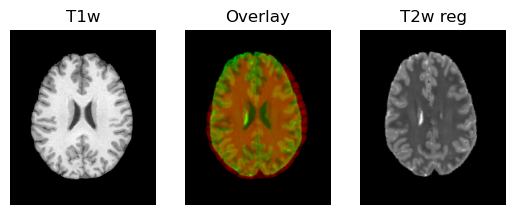

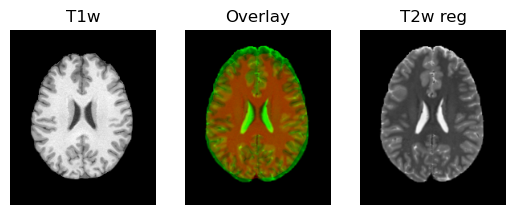

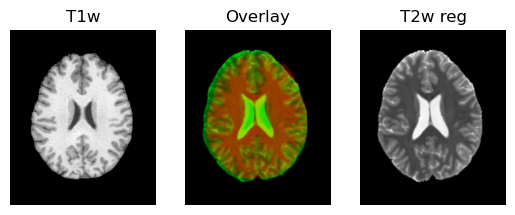

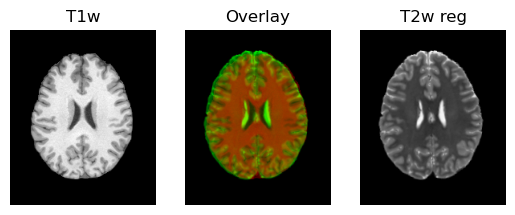

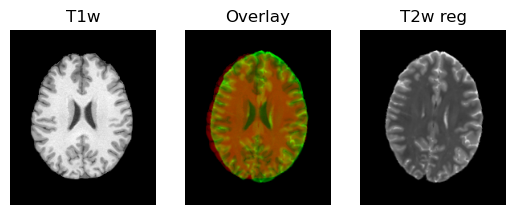

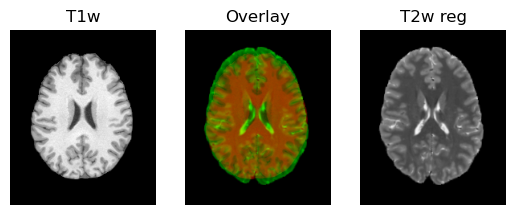

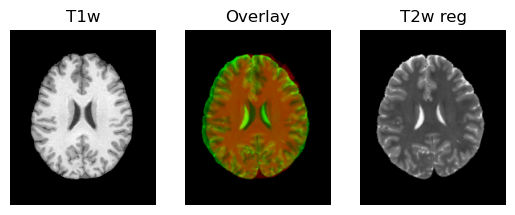

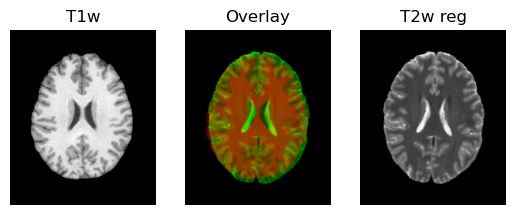

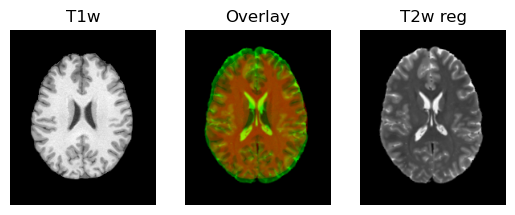

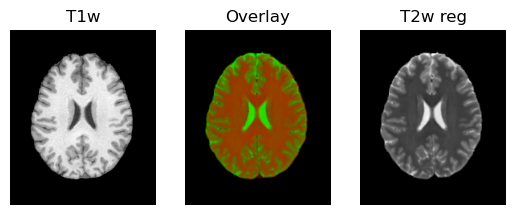

In [7]:
showresults = range(1, 11) # choose the directories to plot the results for ([-1]=show all, [0]=none)
register = [0] # list of indeces to perform registration for ([-1]=all, [0]=none)

for dir in sorted(os.listdir(datadir)):
    idx = int(dir[-2:])
    # Run only in directories with skull-stripped images
    if ((idx in register or idx in showresults) or (showresults[0] == -1 or register[0] == -1)) and os.path.exists(os.path.join(datadir, dir, "T1w_1mm_bet.nii.gz")):
        # Show current directory
        print(f"Analyzing images for patient {dir[-3:]}")
        
        child_temp = os.path.join(results_dir_temp, dir[-3:])
        child_reg = os.path.join(results_dir_reg, dir[-3:])
        # If we want to perform the registration
        if (register[0] == -1) or (idx in register):
            # Read in images
            T1w = nib.load(os.path.join(datadir, dir, "T1w_1mm_bet.nii.gz"))
            T2w = nib.load(os.path.join(datadir, dir, "T2w_1mm_noalign_bet.nii.gz"))
            if idx < 11:
                FA = nib.load(os.path.join(datadir, dir, "FA_deformed_bet.nii.gz"))
                ADC = nib.load(os.path.join(datadir, dir, "ADC_deformed_bet.nii.gz"))
                transformFA = registerimg(T1w, FA, rigid=False)
            transformT2w = registerimg(T1w, T2w, rigid=True)
            T1wdata = T1w.get_fdata()
            if idx < 11:
                FAreg = transformFA.transform(FA.get_fdata())
                ADCreg = transformFA.transform(ADC.get_fdata())
            T2wreg = transformT2w.transform(T2w.get_fdata())
            
            
            if idx < 11:
                FAtemp = torch.tensor(FAreg)
                ADCtemp = torch.tensor(ADCreg)
                FAtemp = nn.functional.interpolate(FAtemp[None, None], size=FA.get_fdata().shape, mode='trilinear')
                ADCtemp = nn.functional.interpolate(ADCtemp[None, None], size=ADC.get_fdata().shape, mode='trilinear')
                FAtemp = FAtemp[0, 0].numpy()
                ADCtemp = ADCtemp[0, 0].numpy()
                if not os.path.exists(child_reg):
                    os.mkdir(child_reg)
                nib.save(nib.Nifti1Image(FAtemp, FA.affine), os.path.join(child_reg, 'FA_align.nii.gz'))
                nib.save(nib.Nifti1Image(ADCtemp, ADC.affine), os.path.join(child_reg, 'ADC_align.nii.gz'))
                nib.save(nib.Nifti1Image(T2wreg, T2w.affine), os.path.join(child_reg, 'T2w_align.nii.gz'))
            else:
                if not os.path.exists(child_temp):
                    os.mkdir(child_temp)
                nib.save(T1w, os.path.join(child_temp, 'T1w.nii.gz'))
                nib.save(nib.Nifti1Image(T2wreg, T2w.affine), os.path.join(child_temp, 'T2w_align.nii.gz'))
                
        # If we just want to display existing registrations:
        else:
            # Ensure registered images exist, then read them in
            if os.path.exists(os.path.join(child_temp, "T2w_align.nii.gz")):
                T1w = nib.load(os.path.join(child_temp, "T1w.nii.gz"))
                T2wreg = nib.load(os.path.join(child_temp, "T2w_align.nii.gz"))
                T2wreg = T2wreg.get_fdata()
                T1wdata = T1w.get_fdata()
            if idx < 11 and os.path.exists(os.path.join(child_reg, "T2w_align.nii.gz")):
                T2wreg = nib.load(os.path.join(child_reg, "T2w_align.nii.gz"))
                FAreg = nib.load(os.path.join(child_reg, "FA_align.nii.gz"))
                ADCreg = nib.load(os.path.join(child_reg, "ADC_align.nii.gz"))
                FAreg = torch.tensor(FAreg.get_fdata())
                ADCreg = torch.tensor(ADCreg.get_fdata())
                FAreg = nn.functional.interpolate(FAreg[None, None], size=T1wdata.shape, mode='trilinear')
                ADCreg = nn.functional.interpolate(ADCreg[None, None], size=T1wdata.shape, mode='trilinear')
                FAreg = FAreg[0, 0].numpy()
                ADCreg = ADCreg[0, 0].numpy()
                T2wreg = T2wreg.get_fdata()
            else:
                print(f"Error: No registration found for patient {dir[-3:]}")
                break

        # Plot the registration results for selected folders
        if (showresults[0] == -1) or (idx in showresults):
            regtools.overlay_slices(T1wdata, T2wreg, None, 2,
                        "T1w", "T2w reg")
            if idx > 10:
                regtools.overlay_slices(T1wdata, FAreg, None, 2,
                                        "T1w", "FA reg")

                regtools.overlay_slices(T1wdata, ADCreg, None, 2,
                                        "T1w", "ADC reg")